In [1]:
%load_ext autoreload
%autoreload 2

# standard
import sys

# env specific
import numpy as np
import scipy.constants as pc
import matplotlib.pyplot as plt
from matplotlib import rcParams

# custom
sys.path.append('e:\\Dropbox\\py_projects\\signal\\signal')
# print(sys.path)
import src.signallib as sl

In [2]:
titlefont = 'Gill Sans MT'
mainfont = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [mainfont, titlefont]

rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

## Create time-series signals


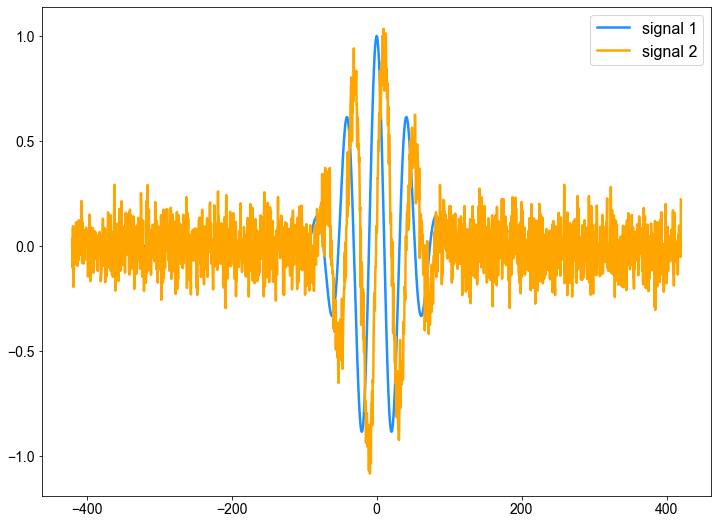

In [3]:
# create time-series signals from the same time vector
WAVELENGTH = 42 # wavelength of main pulse (sets the time scale)
WAVENUMBER = 2*pc.pi / WAVELENGTH
NPERIOD = 10 # number of periods of the time range of observation of the pulse
T_RESOLUTION = 0.01*WAVELENGTH # sampling time 
tvec = np.arange(-NPERIOD*WAVELENGTH,(NPERIOD)*WAVELENGTH,T_RESOLUTION) # time vector common to both signals

# gaussian pulse with oscillations
SIG_WIDTH = 1*WAVELENGTH # width of the gaussian pulse in terms of wavelengths
SIG_AMPLITUDE = 1
OSC_AMPLITUDE = 1 # oscillation amplitude
# xvec1 = SIG_AMPLITUDE * np.exp( - tvec**2 / (2 * SIG_WIDTH**2)) * ( 1 + OSC_AMPLITUDE * np.cos(WAVENUMBER * tvec) )
xvec1 = SIG_AMPLITUDE * np.exp( - tvec**2 / (2 * SIG_WIDTH**2)) * np.cos(WAVENUMBER * tvec)

T_SHIFT = 0 # time shift inside the Gaussian term
T_PHI = 10 # time shift inside the cosine term
wn_scale = 1 # scaling factor for the WAVENUMBERber of the second pulse relative to first
# xvec2 = SIG_AMPLITUDE * np.exp( - (tvec - T_SHIFT)**2 / (2 * SIG_WIDTH**2)) * (1 + OSC_AMPLITUDE * np.cos(wn_scale * WAVENUMBER * (tvec - T_PHI)))
xvec2 = SIG_AMPLITUDE * np.exp( - (tvec - T_SHIFT)**2 / (2 * SIG_WIDTH**2)) * np.cos(wn_scale * WAVENUMBER * (tvec - T_PHI))

# add noise
rng = np.random.default_rng(seed=42)
SNR = 10
error_vec = rng.normal(0, SIG_AMPLITUDE/SNR, (len(tvec))) # gaussian error around zero 

xvec2 = xvec2 + error_vec


fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,9))
# plot initial signals
ls = dict(linewidth=2.5)
ls['color'] = 'dodgerblue'
ax.plot(tvec, xvec1, **ls)
ls['color'] = 'orange'
ax.plot(tvec, xvec2, **ls)
leglist = ['signal 1', 'signal 2']
ax.legend(leglist, prop={'size':16, 'family':mainfont})
plt.show()

## Aligning time-series signals: correlation/convolution
---

When two time-series signals are analyzed, it is often useful to align them so that there is maximum overlap between their waveforms. For real valued signals, finding the maximum overlap can be done using either convolution or correlation. This is a form of peak alignment. 

The basic convolution relation is:
$$ f(t)\circ g(t) = \int f(t)g(t-\tau)d\tau $$

In the sample code below, two cosine-like signals with Gaussian envelope are to be aligned for maximum overlap.

It is instructive to vary the relative wavelengths of the signals, their relative phase, the width of the Gaussian pulse, the sampling rate, and the number of signal periods. All of these are available for variation in the code.

This is a more general procedure that does not depend on the type of signals being aligned. 

---
For periodic signals, it is possible to find the "phase-shift" between two periodic signals by the relation: 
$$ \phi = \arccos( \frac{f\cdot g}{|f| |g|}  ) $$
Where the signals are represented by the n-dimensional vectors $f$ and $g$. The number of time samples is $n$. The dot product in the continous function case is the integral: 
$$f(t)\cdot g(t) = \int f(t)g(t)dt$$
Note that this way calculating $\phi$ does not work when the signals are not periodic or the time window of data acquision is not long enough to have captured a large number of periods (>10 is maybe a good rule of thumb?). Also, the signals should be mean subtracted. 

---
For more information on the difference between convolution and correlation, please consult an outside source [there are many](https://en.wikipedia.org/wiki/Convolution).


Correlating pulses yields a 9.6600 offset in time.
=====
Geometric approach yields a 10.0039 offset in time.
=====


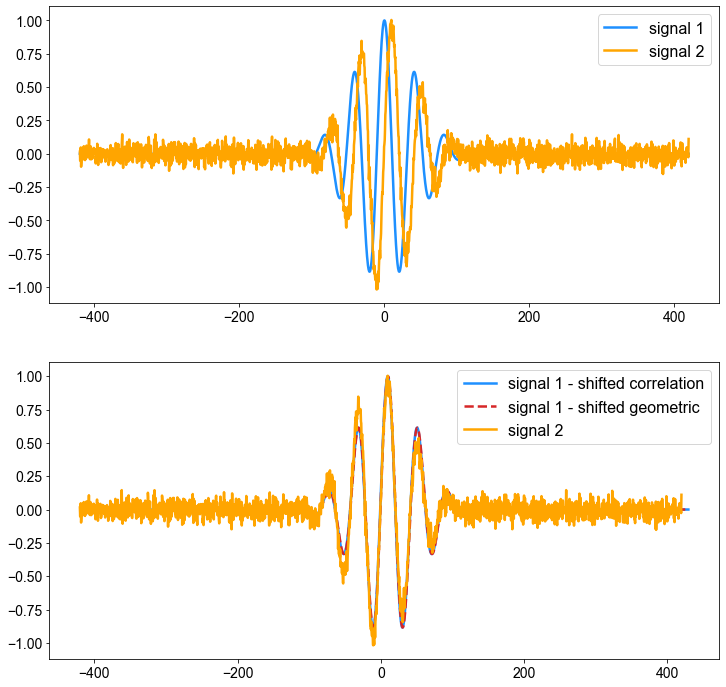

In [242]:

# alignment using correlation approach
indexshift, tcorr = sl.align(xvec1,xvec2)
tshift_corr = indexshift*T_RESOLUTION
print(f'Correlating pulses yields a {tshift_corr:0.4f} offset in time.')
print('=====')

# phase shift geometric approach
sig1 = xvec1 - xvec1.mean()
sig2 = xvec2 - xvec2.mean()
phase_shift = np.arccos((sig1 @ sig2) / np.sqrt(sig1@sig1 * sig2@sig2))
tshift_geo = phase_shift * (WAVELENGTH/(2*pc.pi))
print(f'Geometric approach yields a {tshift_geo:0.4f} offset in time.')
print('=====')


fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,12))

# plot initial signals
ls = dict(linewidth=2.5)
ls['color'] = 'dodgerblue'
axs[0].plot(tvec, xvec1, **ls)
ls['color'] = 'orange'
axs[0].plot(tvec, xvec2, **ls)
leglist = ['signal 1', 'signal 2']
axs[0].legend(leglist, prop={'size':16, 'family':mainfont})

# plot best overlap signals 
ls['color'] = 'dodgerblue'
# axs[1].plot(tvec + toffsetxcorr, xvec1, **ls)
axs[1].plot( tvec + tshift_corr, xvec1, **ls)
ls['color'] = 'tab:red'
axs[1].plot( tvec + tshift_geo, xvec1, **ls,linestyle='--')
ls['color'] = 'orange'
axs[1].plot(tvec, xvec2, **ls)
leglist = ['signal 1 - shifted correlation', 'signal 1 - shifted geometric', 'signal 2']
axs[1].legend(leglist, prop={'size':16, 'family':mainfont})
plt.show()

## Rescaling the time-axis to match a known frequency 
---

Suppose that we are interested in measuring a physical oscillation in space, $S = S(z)$, but our measurement apparatus is such that it returns a digitized voltage waveform in time, $s = s(t)$. The measured waveform is in general a transformation of the physical oscillation. If the measurement is well-behaved, then we can usually assume that things behave linearly to first order, $s(t) = A S(z(t)) + B + E(t)$. Where, $A$ is a scaling factor for the amplitude, $B$ is an offset, and $E(t) \ll A S(z(t))$ is a "catch-all" error term. The space variable, $z$, expressed in time is also assumed linear to first order with some error term, $z(t) = a_1 t + a_0 + e(t)$, where again we assume $e(t) \ll a_1 t + a_0$.

The amplitude scaling, $A$, and offset, $B$, are found by doing some sort of response calibration of the measurement instrument. The $a_0$ term is an arbitrary phase. The signal error, $E(t)$ can, in general, have its own time structure and along with the dispersive error term $e(t)$ can act to distort the spectral content of the signal. The scaling factor $a_1$ is not known, but it is a kind of "speed" that relates the spatial scale of the physical oscillation to the time scale of the measured signal.

---

Assuming that the spatial oscillation we are trying to measure has some main frequency that is present in the measured waveform, we can use it to find the scaling between $z$ and $t$. 

Suppose, 
$$
    S(z) = b_*\cos(k_* z) + \sum_{i\neq i_*}b_i \cos(k_i z) \approx b_*\cos(k_* z)    
$$
is a Fourier expansion of the physical oscillation with a __known__ main wavelength $\lambda_* = 2\pi/k_*$. This wavelength is known from our physical model of the system. 

Now, from the linearity of the response and time scaling, we expect the measured signal to also have a dominant term in its Fourier expansion and the errors to contribute as an increase to the harmonic content:
$$
    s(t) = c_*\cos(\omega_* t) + \sum_{i\neq i_*}c_i \cos(\omega_i t)
$$

What we are after is the "speed" that connects the main/central frequency in the spatial oscillation to that of the measured time-series signal: 
$$
    k_* = \omega_* / a_1
$$

The main wavelength is known and we find the main frequency in the signal as the largest amplitude in its Fourier decomposition. In practice, we perform a discrete FFT on the time-series and find $a_1$ from the above relation. 

Finding, $a_1$ in this way, relies on the knowledge of the main wavelength of the spatial oscillation being measured. In other scenarios, it may be that we know $a_1$ and want to extract an estimate of $\lambda_*$ from the measured signal. Then, we will again use an FFT to find the dominant frequency in the measured signal and scale that to find an estimate for $\lambda_*$.

nlen2 = 2048
sigfft.size = 2048


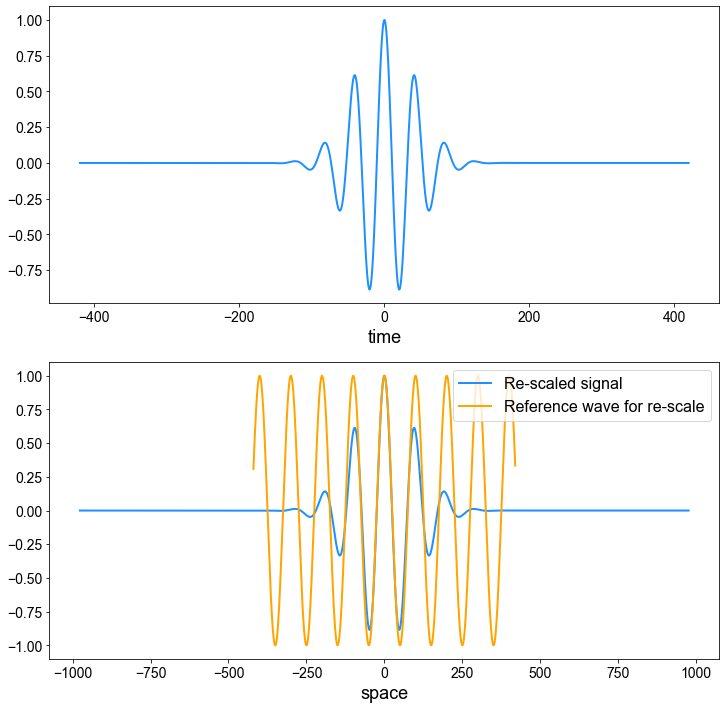

In [4]:


signal_temp = xvec1
# rescale based on known central wavelength
RESCALE_WAVELENGTH = 100

timescale, timeshift, fmain, sfreq, sfft = sl.fft_scale_phase(tvec, signal_temp, RESCALE_WAVELENGTH, mode='max', power=2, freqlims='auto')

# tvec = tscale*tvec
tvec_rescaled = timescale*(tvec + timeshift)

# plot initial signals
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(12,12))

ls = dict(linewidth=2,linestyle='-',marker='o',ms=0,mfc='none', alpha=1, color='dodgerblue')
axs[0].plot(tvec, signal_temp , **ls)

fs = dict(fontsize=18, color='black')
axs[0].set_xlabel('time', **fs)

axs[1].plot(tvec_rescaled, signal_temp - signal_temp.mean(), **ls)

# plot a wave at the central wavelength
ls['color'] = 'orange'
axs[1].plot(tvec, SIG_AMPLITUDE*np.cos((2*pc.pi/RESCALE_WAVELENGTH)*(tvec)), **ls)

axs[1].set_xlabel('space', **fs)
leglist = ['Re-scaled signal', 'Reference wave for re-scale']
axs[1].legend(leglist, prop={'size':16, 'family':mainfont})

# plt.xlim([-50,50])
plt.show()

(0.0, 0.1)

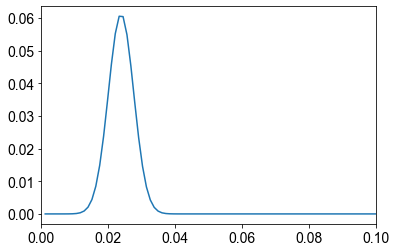

In [8]:
plt.plot(sfreq[sfreq>0], np.abs(sfft[sfreq>0]))
plt.xlim([0,0.1])

In [9]:
signal_temp.size

2000

In [10]:
np.argmax(np.abs(sfft[sfreq>0]) )

19

In [11]:
sfreq[sfreq>0][19]

0.023251488095237218

In [12]:
fmain

0.023251488095237218

In [13]:
timeshift

0.0

In [14]:
1/WAVELENGTH

0.023809523809523808

In [6]:
sfreq.size

2048

In [329]:
tvec.size

2000

In [359]:
(augment_factor//2)

5

## Oversampling and zero padding FFT
---

The n-point discrete Fourier Transform (DFT) computed with the efficient Fast Fourier Transform (FFT) algorithm is most efficient when n is a power of 2. It is therefore adventageous to zero-pad the input signal to the nearest power of 2 before FFT. This is implemented in np.fft.fft when the specified length of the signal is longer than the ndarray passed as the signal.

The idea of zero-padding can be carried into the Fourier space in order to increase the sampling rate. By padding the FFT with zeros into higher frequencies, the signal recovered from the inverse FFT will have a higher sampling rate.  



In [24]:
signal_temp = xvec2
# rescale based on known central wavelength
RESCALE_WAVELENGTH = 100

timescale, timeshift, fmain, sfreq, sfft = sl.fft_scale_phase(tvec, signal_temp, RESCALE_WAVELENGTH, mode='max', power=2, freqlims='auto')

print(f'signal length = {signal_temp.size}')
print(f'FFT length = {sfft.size}')

signal length = 2000
FFT length = 2048


10000
10001


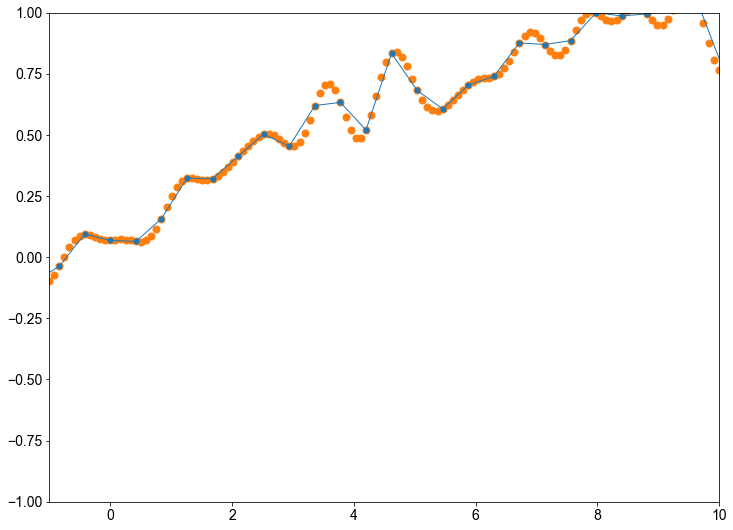

In [32]:
augment_factor = 5 # time resolution increase
# npad = tvec.size*(augment_factor - 1)
# sfftpad = np.pad(np.fft.fftshift(sfft), npad//2, mode='constant', constant_values=0)
# xvec1highsmaple = np.fft.ifft(np.fft.ifftshift(sfftpad))
xvec1highsmaple = sl.fft_resample(signal_temp, augment_factor)
print(xvec1highsmaple.size)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,9))

ls = {'linewidth':1,'marker':'o', 'markersize':5}
ax.plot(tvec, signal_temp, **ls, zorder=1)
tvec1 = np.arange(-NPERIOD*WAVELENGTH,(NPERIOD)*WAVELENGTH,T_RESOLUTION/(augment_factor)) # time vector common to both signals
print(tvec1.size)
ls = {'linewidth':0,'marker':'o', 'markersize':7}
ax.plot(tvec1[:xvec1highsmaple.size], xvec1highsmaple.size * xvec1highsmaple, **ls, zorder=0)

ax.set_xlim([-1,10])
ax.set_ylim([-1,1])
plt.show()

In [414]:
tvec1.size

14000

In [21]:
xvec1highsmaple

array([-3.46944695e-21+8.67130698e-34j,  3.46944695e-21-5.59275363e-22j,
        1.38777878e-21-8.74450007e-22j, ...,
        1.38777878e-21-2.42864012e-21j,  6.93889390e-21+5.52837339e-21j,
       -5.55111512e-21-1.04917795e-21j])

In [381]:
(augment_factor//2) * tvec.size//2

2000

In [391]:
T_RESOLUTION/(augment_factor-1)

0.08399999999999999